In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/movielens-25m-dataset/ml-25m-README.html
/kaggle/input/movielens-25m-dataset/ml-25m/ml-25m/movies.csv
/kaggle/input/movielens-25m-dataset/ml-25m/ml-25m/ratings.csv
/kaggle/input/movielens-25m-dataset/ml-25m/ml-25m/genome-tags.csv
/kaggle/input/movielens-25m-dataset/ml-25m/ml-25m/README.txt
/kaggle/input/movielens-25m-dataset/ml-25m/ml-25m/genome-scores.csv
/kaggle/input/movielens-25m-dataset/ml-25m/ml-25m/tags.csv
/kaggle/input/movielens-25m-dataset/ml-25m/ml-25m/links.csv


In [2]:
import gc
import scipy.sparse as sp
from sklearn.preprocessing import LabelEncoder
from scipy.sparse.linalg import svds

In [3]:
DIR = "/kaggle/input/movielens-25m-dataset/ml-25m/ml-25m"

In [4]:
usecols = ["userId", "movieId", "rating", "timestamp"]
dtypes = {"userID": "int32", "movieID": "int32", "rating": "float32", "timestamp": "int64"}

# Start with "ratings.csv"
ratings = pd.read_csv(f"{DIR}/ratings.csv", usecols=usecols, dtype=dtypes)
ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [5]:
# Change the format of timestamp
ratings["ts"] = pd.to_datetime(ratings["timestamp"], unit="s")
ratings = ratings.sort_values("ts").reset_index(drop=True)
ratings[["userId", "movieId", "rating", "ts"]].head()

,userId,movieId,rating,ts
0,2262,21,3.0,1995-01-09 11:46:49
1,2262,1079,3.0,1995-01-09 11:46:49
2,2262,47,5.0,1995-01-09 11:46:49
3,102689,1,4.0,1996-01-29 00:00:00
4,102689,39,5.0,1996-01-29 00:00:00


In [6]:
# Use the data of 2015-current
min_year = 2015
ratings = ratings[ratings["ts"].dt.year >= min_year].reset_index(drop=True)
ratings.shape

(7563741, 5)

#### <span style="background-color:#C0FFFF"> K-core Filtering for Train set only </span>

In [7]:
def kcore(df, k=10):
    d = df
    while True:
        before = len(d)
        d = d[d.groupby("userId")["userId"].transform("count") >=k ]    # users more than x10
        d = d[d.groupby("movieId")["movieId"].transform("count") >=k ]  # movies rated more than x10
        after = len(d)
        if before==after: break
    return d.reset_index(drop=True)

In [8]:
ratings = kcore(ratings, k=10)
ratings.shape

(7440152, 5)

#### <span style="background-color:#C0FFFF"> Split train set to train and validation sets (based on chronological order)</span>

In [9]:
# train (80%) / valid (10%) / test (10%) set
train = ratings.iloc[:int(len(ratings)*0.8)].copy()
valid = ratings.iloc[int(len(ratings)*0.8):int(len(ratings)*0.9)].copy()
test = ratings.iloc[int(len(ratings)*0.9):].copy()

len(train), len(valid), len(test)

(5952121, 744015, 744016)

#### <span style="background-color:#C0FFFF"> Label Encoding </span>

In [10]:
le_u, le_i = LabelEncoder(), LabelEncoder()
train["u"] = le_u.fit_transform(train["userId"])
train["i"] = le_i.fit_transform(train["movieId"])
train.head()

,userId,movieId,rating,timestamp,ts,u,i
0,86188,1196,3.5,1420070535,2015-01-01 00:02:15,19705,873
1,86188,1036,4.0,1420070551,2015-01-01 00:02:31,19705,772
2,86188,58559,3.0,1420070568,2015-01-01 00:02:48,19705,8945
3,86188,110,2.5,1420070579,2015-01-01 00:02:59,19705,93
4,86188,293,3.5,1420070583,2015-01-01 00:03:03,19705,245


In [11]:
# Encode userId and movieId same as train set
def encode_u_i(df):
    d = df[df["userId"].isin(le_u.classes_) & df["movieId"].isin(le_i.classes_)].copy()
    
    d["u"] = le_u.transform(d["userId"])
    d["i"] = le_i.transform(d["movieId"])

    return d

In [12]:
valid = encode_u_i(valid)
test = encode_u_i(test)

n_users, n_items = len(le_u.classes_), len(le_i.classes_)
n_users, n_items

(37216, 19814)

### <span style="color:blue"> Create sparse (user-item) matrix → Learn latent factors using SVD </span>

In [13]:
n_users = train["u"].max() + 1
n_items = train["i"].max() + 1

# Generate a sparse matrix (data, (row, col))
R = sp.coo_matrix(
    (train["rating"].values,
    (train["u"].values, train["i"].values)),
    shape = (n_users, n_items)
).tocsr()

K = 64
u_f, s, vt = svds(R.astype("float32"), k=K)

S = np.diag(s)
U = u_f @ S      # Users embedding vector (n_users, K)
V = vt.T         # Items embedding vector (n_items, K)


# Function to predict how much a user will like an item 
# by taking the dot product of their embedding vectors.
def mf_score(u_idx, i_idx):
    # embedding vector(s) of selected users * embedding vector(s) of selected items
    return (U[u_idx] * V[i_idx]).sum(axis=1)

### <span style="color:blue"> Simple ranking metrics function (Precision@K, Recall@K) </span>

In [14]:
def precision_recall_at_k(df, k=10, threshold=4.0):
    precs, recs = [], []
    for u, g in df.groupby(["u"]):
        g = g.copy()
        g["score"] = mf_score(g["u"].values, g["i"].values)   # -> u_idx, i_idx
        g = g.sort_values("score", ascending=False)    # descending
        topk = g.head(k)    # k: TP + FP (high score)

        hits = (topk["rating"] >= threshold).sum()     # actual high rates among predicted with high scores
        total_pos = (g["rating"] >= threshold).sum()   # actually highly rated

        if k > 0: precs.append(hits / k)                     # TP / (TP + FP)
        if total_pos > 0: recs.append(hits / total_pos)      # TP / (TP + FN)

    return (np.mean(precs) if precs else 0.0,
            np.mean(recs) if recs else 0.0)

### <span style="color:blue"> Measure MF baseline performance (on the test set) </span>

In [15]:
p10, r10 = precision_recall_at_k(test, k=10, threshold=4.0)
print({"MF_Precision@10":round(p10, 4), "MF_Recall@10":round(r10, 4)})

K_list = [32, 64, 96]
for K in K_list:
    u_f, s, vt = svds(R.astype("float32"), k=K)
    S = np.diag(s)
    U = u_f @ S
    V = vt.T
    prec, rec = precision_recall_at_k(test, k=10, threshold=4.0)
    print(f"K={K} : Precision@10: {prec:.4f} & Recall@10: {rec:.4f}")

{'MF_Precision@10': 0.3877, 'MF_Recall@10': 0.677}
K=32 : Precision@10: 0.3878 & Recall@10: 0.6770
K=64 : Precision@10: 0.3877 & Recall@10: 0.6770
K=96 : Precision@10: 0.3857 & Recall@10: 0.6755


### <span style="color:blue"> Generate and save Top-N candidate recommendations (*based on Score*) per user </span>

In [16]:
def score_get_topk(df, k=100):
    out = []
    for u, g in df.groupby(["u"]):
        g = g.copy()
        g["score"] = mf_score(g["u"].values, g["i"].values)
        out.append(g.sort_values("score", ascending=False).head(k))

    return pd.concat(out, axis=0).reset_index(drop=True)

test_top100 = score_get_topk(test, k=100)
test_top100.head()

,userId,movieId,rating,timestamp,ts,u,i,score
0,3,88140,3.5,1566089895,2019-08-18 00:58:15,0,11162,3.579875
1,3,6365,4.0,1566089715,2019-08-18 00:55:15,0,4742,3.079805
2,3,6537,3.5,1566089810,2019-08-18 00:56:50,0,4857,2.940701
3,3,88125,3.5,1566091623,2019-08-18 01:27:03,0,11157,2.744191
4,3,81834,3.5,1566091630,2019-08-18 01:27:10,0,10695,2.680147


### <span style="color:blue"> Item Feature Engineering (**Genres** + **Popularity** + **Recency**) </span>

In [17]:
# Use 'movie.csv'
movies = pd.read_csv(f"{DIR}/movies.csv")
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [18]:
# Exclude cold-start (use only encoded by ratings.csv)
movies = movies[movies["movieId"].isin(le_i.classes_)].copy()
movies["i"] = le_i.transform(movies["movieId"])

# Preprocessing for "genre" -> new feature
movies["genres"] = movies["genres"].fillna("(no genres listed)")
movies["genres_list"] = movies["genres"].str.split("|")

all_genres = sorted({g for gl in movies["genres_list"] for g in gl})
all_genres[:10]

['(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy']

In [19]:
for g in all_genres:
    movies[f"genre_{g}"] = movies["genres_list"].apply(lambda L: int(g in L))

movies.head()

,movieId,title,genres,i,genres_list,genre_(no genres listed),genre_Action,genre_Adventure,genre_Animation,genre_Children,...,genre_Film-Noir,genre_Horror,genre_IMAX,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0,"[Adventure, Animation, Children, Comedy, Fantasy]",0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1,"[Adventure, Children, Fantasy]",0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men (1995),Comedy|Romance,2,"[Comedy, Romance]",0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3,"[Comedy, Drama, Romance]",0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II (1995),Comedy,4,[Comedy],0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
movies.columns

Index(['movieId', 'title', 'genres', 'i', 'genres_list',
       'genre_(no genres listed)', 'genre_Action', 'genre_Adventure',
       'genre_Animation', 'genre_Children', 'genre_Comedy', 'genre_Crime',
       'genre_Documentary', 'genre_Drama', 'genre_Fantasy', 'genre_Film-Noir',
       'genre_Horror', 'genre_IMAX', 'genre_Musical', 'genre_Mystery',
       'genre_Romance', 'genre_Sci-Fi', 'genre_Thriller', 'genre_War',
       'genre_Western'],
      dtype='object')

In [21]:
item_stats = (train.groupby("i").agg(item_count=("rating", "size"),    # popularity
                                     item_mean=("rating", "mean"),     # quality
                                     item_last_ts=("ts", "max")).reset_index())    # recency
item_stats.head()

,i,item_count,item_mean,item_last_ts
0,0,11551,3.781447,2018-10-12 09:09:12
1,1,3892,3.398253,2018-10-12 12:17:31
2,2,410,2.906098,2018-10-07 02:08:30
3,3,73,2.534247,2018-05-10 17:19:59
4,4,863,2.992468,2018-10-05 19:47:12


In [22]:
# Normalized recency score (0–1) relative to the min(earliest) timestamp
ts_min = item_stats["item_last_ts"].min()
ts_max = item_stats["item_last_ts"].max()
denom = (ts_max - ts_min).total_seconds() or 1
item_stats["item_recency01"] = (item_stats["item_last_ts"] - ts_min).dt.total_seconds() / denom

# Merge item_stats on movies dataframe
movie_feats = movies.merge(item_stats, on="i", how="left")
movie_feats["item_count"] = movie_feats["item_count"].fillna(0) 
movie_feats["item_mean"] = movie_feats["item_mean"].fillna(movie_feats["item_mean"].median())
movie_feats["item_recency01"] = movie_feats["item_recency01"].fillna(0)

In [23]:
# Selecting the final item feature columns to be used -> final data frame: 'item_features'
genres_cols = [c for c in movie_feats.columns if c.startswith("genre_")]
item_cols = ["i", "movieId", "title", "item_count", "item_mean", "item_recency01"] + genres_cols
item_features = movie_feats[item_cols].copy()
item_features.head()

,i,movieId,title,item_count,item_mean,item_recency01,genre_(no genres listed),genre_Action,genre_Adventure,genre_Animation,...,genre_Film-Noir,genre_Horror,genre_IMAX,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
0,0,1,Toy Story (1995),11551,3.781447,0.999871,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,2,Jumanji (1995),3892,3.398253,0.999998,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2,3,Grumpier Old Men (1995),410,2.906098,0.994744,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,3,4,Waiting to Exhale (1995),73,2.534247,0.850040,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,4,5,Father of the Bride Part II (1995),863,2.992468,0.993519,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
for c in genres_cols:
    item_features[c] = item_features[c].astype("uint8")    # int64 -> unit8

# change dtype (memory)
item_features["item_count"] = item_features["item_count"].astype("int32")
item_features["item_mean"] = item_features["item_mean"].astype("float32")
item_features["item_recency01"] = item_features["item_recency01"].astype("float32")

item_features.shape

(19814, 26)

In [25]:
TOPK = 50
BATCH = 500
OUT_DIR = "/kaggle/working/batch"
os.makedirs(OUT_DIR, exist_ok=True)

# Indices dictioniary if the users' "seen" items 
seen_dict = (
    train.groupby("u")["i"].apply(lambda x: x.values.astype(np.int64)).to_dict()
)

Vt = V.T.astype(np.float32, copy=False)    # (K, n_items)

all_users = np.arange(n_users, dtype=np.int64)
part_files = []
for bi, start in enumerate(range(0, n_users, BATCH)):
    end = min(start + BATCH, n_users)
    batch_users = all_users[start:end]
    Ubatch = U[batch_users].astype(np.float32, copy=False)

    scores = Ubatch @ Vt     # (batch, n_items)

    # Mask as -np.inf using seen_dict
    for j, u in enumerate(batch_users):
        seen_items = seen_dict.get(u, None)
        if seen_items is not None and len(seen_items) > 0:
            scores[j, seen_items] = -np.inf

    idx_topk = np.argpartition(scores, -TOPK, axis=1)[:, -TOPK:]          # indices for the top K items in each user's row (batch, TOPK)
    part_scores = np.take_along_axis(scores, idx_topk, axis=1)            # scores at the idx_topk (batch, TOPK)
    order_in_part = np.argsort(-part_scores, axis=1)                      # "sorting index" of topk scores
    
    topk_idx_sorted = np.take_along_axis(idx_topk, order_in_part, axis=1) # item indices from sorted (batch, TOPK)
    topk_scores = np.take_along_axis(part_scores, order_in_part, axis=1)  # sorted scores (batch, TOPK)

    uu = np.repeat(batch_users, TOPK).astype(np.int64)
    ii = topk_idx_sorted.reshape(-1).astype(np.int64)   # flattened TOPK idx
    ss = topk_scores.reshape(-1).astype(np.float32)     # flattened TOPK scores
    
    df_part = pd.DataFrame({"u": uu, "i": ii, "mf_score": ss})

    part_path = f"{OUT_DIR}/candidates_part_{bi:03d}.parquet"
    df_part.to_parquet(part_path, index=False)
    part_files.append(part_path)

    del scores, idx_topk, part_scores, order_in_part, topk_idx_sorted, topk_scores, df_part, uu, ii, ss
    gc.collect()

In [26]:
from sklearn.preprocessing import normalize

# Label valid and test set to evaluate the predictions
valid_label = valid.copy()
valid_label["label"] = (valid_label["rating"] >= 4.0).astype(np.int8)    # label only when ratings higher than 4.0
valid_label = valid_label[["u", "i", "label"]]

test_label = test.copy()
test_label["label"] = (test_label["rating"] >= 4.0).astype(np.int8)      # label only when ratings higher than 4.0
test_label = test_label[["u", "i", "label"]]

valid_users = set(valid["u"].unique())
test_users = set(test["u"].unique())

genre_cols = [c for c in item_features.columns if c.startswith("genre_")]

# get mean (one-hot vec) of genres by each user
# which genre each user prefers
user_genre = (
    train.merge(item_features[["i"] + genre_cols], on="i").groupby("u")[genre_cols].mean().fillna(0.0)
)

# user_genre.head()

# L2 normalization -> cosine similarity with dot product
user_genre = pd.DataFrame(
    normalize(user_genre.values, axis=1), index=user_genre.index, columns = genre_cols
).astype("float32")

user_genre.head()

,genre_(no genres listed),genre_Action,genre_Adventure,genre_Animation,genre_Children,genre_Comedy,genre_Crime,genre_Documentary,genre_Drama,genre_Fantasy,genre_Film-Noir,genre_Horror,genre_IMAX,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western
u,,,,,,,,,,,,,,,,,,,,
0,0.0,0.524161,0.323198,0.076656,0.068369,0.258973,0.180245,0.006215,0.368777,0.122235,0.008287,0.078728,0.130522,0.010359,0.099446,0.105661,0.401926,0.389495,0.043507,0.010359
1,0.0,0.228558,0.163256,0.065302,0.065302,0.391814,0.424465,0.000000,0.555070,0.097953,0.000000,0.032651,0.032651,0.000000,0.097953,0.261209,0.163256,0.391814,0.032651,0.000000
2,0.0,0.234978,0.313304,0.274141,0.117489,0.078326,0.234978,0.000000,0.704934,0.313304,0.000000,0.000000,0.000000,0.000000,0.039163,0.234978,0.078326,0.156652,0.117489,0.000000
3,0.0,0.493636,0.435561,0.319411,0.290374,0.319411,0.058075,0.000000,0.145187,0.116150,0.000000,0.000000,0.319411,0.058075,0.029037,0.087112,0.319411,0.145187,0.058075,0.000000
4,0.0,0.406509,0.360489,0.340036,0.145730,0.329809,0.125276,0.017897,0.470425,0.199419,0.002557,0.099710,0.092040,0.056246,0.074143,0.148286,0.276119,0.230099,0.061360,0.007670


### <span style="color:blue"> Hybrid Ranking </span>

In [27]:
# Current: item_features, user_genre, genre_cols, valid_labels, test_labels, part_files
FEATURES = ["mf_score", "item_count", "item_mean", "item_recency01", "genre_sim"] + list(genres_cols)

def build_table(parts, target_users, labels_df, max_rows=None):
    out, n = [], 0
    for p in parts:    # for each user (topk recommendation data)
        df = pd.read_parquet(p, columns=["u", "i", "mf_score"])    # data saved after scoring (SVD)
        df = df[df["u"].isin(target_users)]    # only target users, here, users with (ratings >= 4.0) data
        if df.empty:
            continue

        df = df.merge(item_features, on="i", how="left")    # merge recommendation list & item features on item
        ug = user_genre.reindex(df["u"].values).reset_index(drop=True)   # get user genre preference
        ug.columns = [c + "_user" for c in ug.columns]
        df = pd.concat([df.reset_index(drop=True), ug], axis=1)   # score data + item features + genre preference

        # here, ug columns are always the same for one user
        df["genre_sim"] = (df[genres_cols].values * df[[c + "_user" for c in genres_cols]].values).sum(axis=1).astype("float32")
        # print(df.head())
        df = df.merge(labels_df, on=["u", "i"], how="left")    # apply to valid/test set
        df["label"] = df["label"].fillna(0).astype("int8")

        usecol = ["u", "i", "label"] + FEATURES
        df = df[usecol].copy()
        df["mf_score"] = df["mf_score"].astype("float32")

        out.append(df)
        n += len(df)
        del df, ug
        gc.collect()

        if max_rows and n >= max_rows:
            break

    return pd.concat(out, ignore_index=True) if out else pd.DataFrame(columns=use)


In [28]:
train_rank = build_table(part_files, valid_users, valid_label, max_rows=2_000_000)
test_rank = build_table(part_files, test_users, test_label, max_rows=None)

print("train_rank:", train_rank.shape, "pos rate:", float(train_rank["label"].mean()))
print("test_rank :", test_rank.shape,  "pos rate:", float(test_rank["label"].mean()))

train_rank: (200150, 28) pos rate: 0.038840869347989006
test_rank : (168700, 28) pos rate: 0.03087729697688204


### <span style="color:blue"> LightGBM </span>

In [29]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

FEATURES_PLUS = ["mf_score","item_count","item_mean","item_recency01","genre_sim"] + list(genres_cols)

msk = (train_rank["u"] % 2 == 0)    # Even: True -> Train / Odd: False -> Valid
X_tr = train_rank.loc[msk, FEATURES_PLUS].values
y_tr = train_rank.loc[msk, "label"].values.astype("int8")
X_va = train_rank.loc[~msk, FEATURES_PLUS].values
y_va = train_rank.loc[~msk, "label"].values.astype("int8")

params = {
    "objective":"binary",
    "metrics":"auc",
    "learning_rate":0.05,
    "num_leaves":63,
    "min_date_in_leaf":50,
    "feature_fraction":0.8,
    "bagging_fraction":0.8,
    "bagging_freq":1,
    "verbosity":-1,
    "force_col_wise":True
}

dtrain = lgb.Dataset(X_tr, label=y_tr, free_raw_data=False)
dvalid = lgb.Dataset(X_va, label=y_va, reference=dtrain, free_raw_data=False)

# Train and Valid
gbm = lgb.train(
    params,
    dtrain,
    num_boost_round=1200,
    valid_sets=[dvalid],
    valid_names=["valid"],
    callbacks=[lgb.early_stopping(stopping_rounds=100), lgb.log_evaluation(period=50)]
)

# Prediction
test_rank = test_rank.assign(
    pred = gbm.predict(test_rank[FEATURES_PLUS].values, num_iteration=gbm.best_iteration)
)

Training until validation scores don't improve for 100 rounds
[50]	valid's auc: 0.639717
[100]	valid's auc: 0.637307
Early stopping, best iteration is:
[19]	valid's auc: 0.642491


In [30]:
test_rank.head()

,u,i,label,mf_score,item_count,item_mean,item_recency01,genre_sim,genre_(no genres listed),genre_Action,...,genre_Horror,genre_IMAX,genre_Musical,genre_Mystery,genre_Romance,genre_Sci-Fi,genre_Thriller,genre_War,genre_Western,pred
0,0,9585,0,3.833796,5554,4.023857,0.999982,1.259645,0,0,...,0,0,0,1,0,1,1,0,0,0.061900
1,0,11162,0,3.579875,5518,3.508789,0.999191,1.682288,0,1,...,0,0,0,0,0,1,1,1,0,0.073727
2,0,871,0,3.163672,8165,4.108512,0.999981,0.368777,0,0,...,0,0,0,0,0,0,0,0,0,0.056649
3,0,4742,1,3.079805,6630,3.423529,0.999364,1.769303,0,1,...,0,1,0,0,0,1,1,0,0,0.079193
4,0,3303,0,3.021405,3365,3.409956,0.999574,1.093902,0,0,...,0,0,0,0,0,1,0,0,0,0.032988


In [31]:
os.makedirs("figure", exist_ok=True)
os.makedirs("data", exist_ok=True)

In [32]:
# evaluation metrics hybrid ranking
def precision_recall_ndcg_at_k(df, k=10, label="label", score="pred"):
    precs, recs, ndcgs = [], [], []
    
    for u, g in df.groupby("u", sort=False):
        g = g.sort_values(score, ascending=False)    # sort the result data based on prediction score
        topk = g.head(k)                 # pick top k scored (predicted) movies
        hits = int(topk[label].sum())    # movies actually rated over 4.0 in the predicted topk
        total_pos = int(g[label].sum())  # movies actually rated over 4.0 
        precs.append(hits / k)              # Precision
        if total_pos > 0:
            recs.append(hits / total_pos)   # Recall

        rel = topk[label].to_numpy()
        if rel.size:
            discounts = 1.0 / np.log2(np.arange(2, rel.size + 2))
            dcg = float((rel * discounts).sum())
            ideal = np.sort(rel)[::-1]
            idcg = float((ideal * discounts).sum()) if ideal.sum() > 0 else 0.0
            ndcgs.append(dcg / idcg if idcg > 0 else 0.0)    # NDCG

    P = float(np.mean(precs)) if precs else 0.0
    R = float(np.mean(recs)) if recs else 0.0
    N = float(np.mean(ndcgs)) if ndcgs else 0.0

    return P, R, N


def metrics_over_K(df, ks, label="label", score="pred"):
    rows = []
    for k in ks:
        P, R, N = precision_recall_ndcg_at_k(df, k=k, label=label, score=score)
        rows.append({"K": k, "Precision": P, "Recall": R, "NDCG": N})
    return pd.DataFrame(rows)

In [33]:
# Compare MF and Hybrid ranking
KS = [5, 10, 20]
df_mf = metrics_over_K(test_rank, KS, label="label", score="mf_score")
df_hyb = metrics_over_K(test_rank, KS, label="label", score="pred")
matrix_tbl = pd.concat([df_mf.assign(Model="MF"), df_hyb.assign(Model="Hybrid")], ignore_index=True)
matrix_tbl.to_csv("/kaggle/working/data/metrics_baseline_vs_hybrid.csv", index=False)

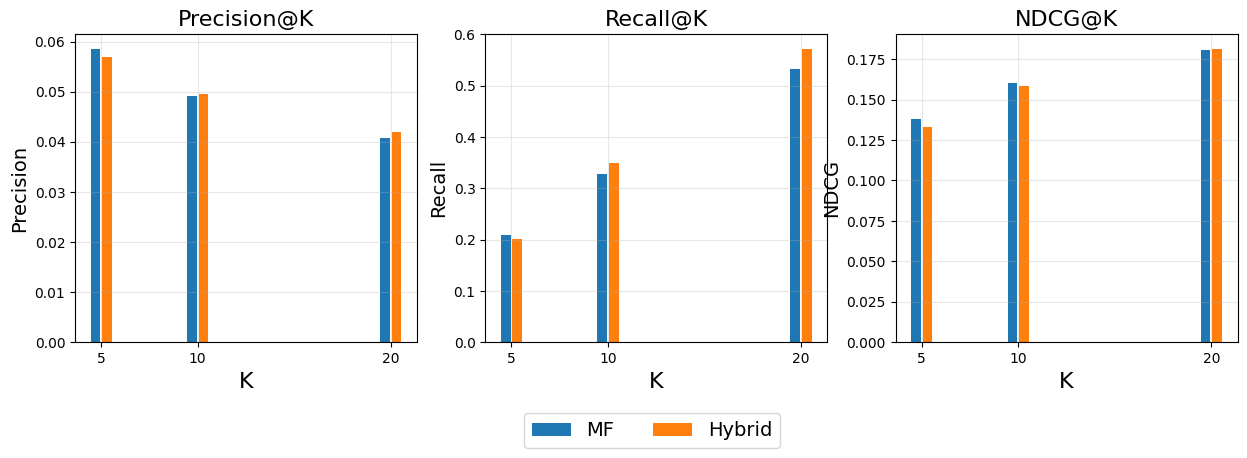

In [34]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharex=True)

for ax, metric in zip(axes, ["Precision", "Recall", "NDCG"]):
    for model, df in [("MF", df_mf), ("Hybrid", df_hyb)]:
        offset = 0.3 if model == "Hybrid" else -0.3 
        ax.bar(df["K"] + offset, df[metric], width=0.5, label=model if metric=="Recall" else "")
    
    ax.set_title(f"{metric}@K", fontsize=16)
    ax.set_xlabel("K", fontsize=16)
    ax.set_ylabel(metric, fontsize=14)
    ax.set_xticks(KS)
    ax.grid(alpha=0.3)
axes[1].legend(ncol=2, bbox_to_anchor=(0.89, -0.2), fontsize=14)

# plt.tight_layout()
out_path = os.path.join("figure/fig_metrics_mf_vs_hybrid.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()
plt.close()

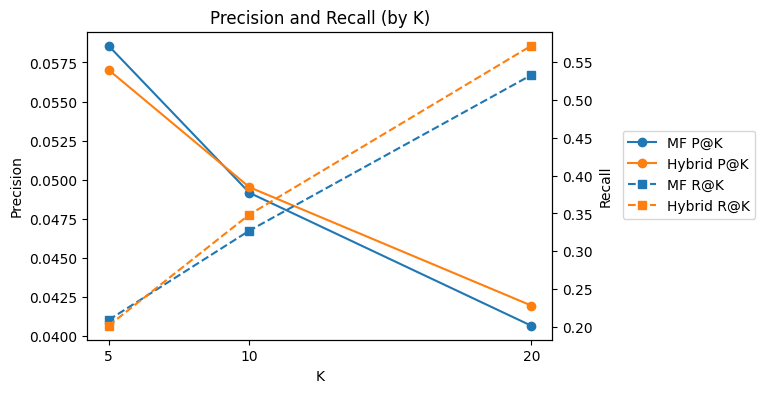

In [35]:
fig, ax1 = plt.subplots(figsize=(6,4))

ax1.plot(df_mf["K"], df_mf["Precision"], "o-", label="MF P@K")
ax1.plot(df_hyb["K"], df_hyb["Precision"], "o-", label="Hybrid P@K")
ax1.set_xlabel("K")
ax1.set_ylabel("Precision")
ax1.set_xticks(KS)

ax2 = ax1.twinx()
ax2.plot(df_mf["K"], df_mf["Recall"], "s--", label="MF R@K")
ax2.plot(df_hyb["K"], df_hyb["Recall"], "s--", label="Hybrid R@K")
ax2.set_ylabel("Recall")

fig.legend(bbox_to_anchor=(1.25, 0.65))
plt.title("Precision and Recall (by K)")
# plt.tight_layout()
out_path = os.path.join("figure/precision_recall_by_K.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
plt.show()


Feature importance plot skipped: Cannot save file into a non-existent directory: 'outputs'


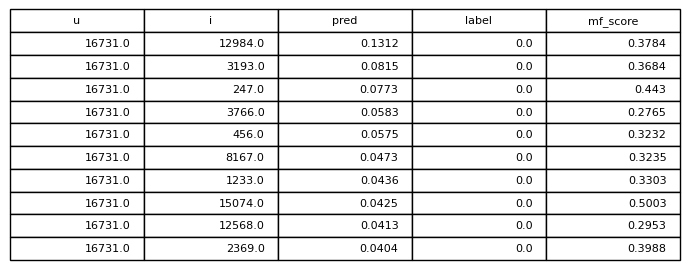

In [36]:
try:
    import numpy as np
    fimp = pd.DataFrame({
        "feature": gbm.feature_name(),
        "importance": gbm.feature_importance(importance_type="gain")
    }).sort_values("importance", ascending=False)

    topN = 15                                                             
    plt.figure(figsize=(7,6))
    plt.barh(fimp["feature"].head(topN)[::-1],
             fimp["importance"].head(topN)[::-1])
    plt.title("Feature Importance (gain) — Top 15")
    plt.xlabel("Importance (gain)")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.savefig(os.path.join("figure/fig_feature_importance_top15.png"), dpi=200)
    plt.close()
    fimp.to_csv("outputs/feature_importances.csv", index=False)
except Exception as e:
    print("Feature importance plot skipped:", e)

sample_u = int(test_rank["u"].sample(1, random_state=42).iloc[0])
sample_tbl = (test_rank[test_rank["u"]==sample_u]
              .sort_values("pred", ascending=False)
              .head(10)[["u","i","pred","label","mf_score"]])
sample_tbl.to_csv("data/sample_top10_user.csv", index=False)

plt.figure(figsize=(7,2.8))
plt.axis("off")
tbl = plt.table(cellText=np.round(sample_tbl.values, 4),
                colLabels=sample_tbl.columns.tolist(),
                loc="center")
tbl.auto_set_font_size(False)
tbl.set_fontsize(8)
tbl.scale(1, 1.2)
plt.tight_layout()
plt.show()
# plt.savefig(os.path.join("figure/fig_sample_top10_user.png"), dpi=300, bbox_inches="tight")
plt.close()

# print("Saved figures:", os.listdir(FIG_DIR))

In [37]:
import os, shutil, glob, pandas as pd, json

ROOT_OUT = "/kaggle/working/outputs"
PARQ_DIR = f"{ROOT_OUT}/parquet"
PARTS_DIR= f"{PARQ_DIR}/candidate_parts" 
FIG_DIR  = f"{ROOT_OUT}/figs"
TABLE_DIR= f"{ROOT_OUT}/tables"
MODEL_DIR= f"{ROOT_OUT}/models"
for d in [PARQ_DIR, PARTS_DIR, FIG_DIR, TABLE_DIR, MODEL_DIR]:
    os.makedirs(d, exist_ok=True)

src_parts = sorted(glob.glob("/kaggle/working/batch/candidates_part_*.parquet"))
for sp in src_parts:
    shutil.copy2(sp, PARTS_DIR)

def safe_to_parquet(df, path):
    if isinstance(df, pd.DataFrame) and len(df) > 0:
        df.to_parquet(path, index=False)

try: safe_to_parquet(item_features, f"{PARQ_DIR}/item_features.parquet")
except: pass
try: safe_to_parquet(user_genre,    f"{PARQ_DIR}/user_genre.parquet")
except: pass
try: safe_to_parquet(valid_label,  f"{PARQ_DIR}/valid_label.parquet")
except: pass
try: safe_to_parquet(test_label,   f"{PARQ_DIR}/test_label.parquet")
except: pass
try: safe_to_parquet(train, f"{PARQ_DIR}/train.parquet")
except: pass

# shutil.make_archive(f"{FIG_DIR}/all_figs", 'zip', "/kaggle/working/figure")

manifest = {
  "parquet": {
    "candidate_parts_glob": "parquet/candidate_parts/candidates_part_*.parquet",
    "item_features":        "parquet/item_features.parquet",
    "user_genre":           "parquet/user_genre.parquet",
    "valid_label":          "parquet/valid_label.parquet",
    "test_label":           "parquet/test_label.parquet",
    "train":                "parquet/train.parquet"
  }
}
with open(f"{ROOT_OUT}/manifest.json", "w") as f:
    json.dump(manifest, f, indent=2)


In [38]:
# import os, shutil, glob, pandas as pd, json

# ROOT_OUT = "/kaggle/working/outputs"
# PARQ_DIR = f"{ROOT_OUT}/parquet"
# FIG_DIR  = f"{ROOT_OUT}/figs"
# TABLE_DIR= f"{ROOT_OUT}/tables"
# MODEL_DIR= f"{ROOT_OUT}/models"
# os.makedirs(PARQ_DIR, exist_ok=True)
# os.makedirs(FIG_DIR,  exist_ok=True)
# os.makedirs(TABLE_DIR,exist_ok=True)
# os.makedirs(MODEL_DIR,exist_ok=True)

# part_files = sorted(glob.glob("/kaggle/working/batch/candidates_part_*.parquet"))

# def safe_to_parquet(df, path):
#     if isinstance(df, pd.DataFrame) and len(df)>0:
#         df.to_parquet(path, index=False)

# try: safe_to_parquet(item_features, f"{PARQ_DIR}/item_features.parquet")
# except: pass
# try: safe_to_parquet(user_genre,    f"{PARQ_DIR}/user_genre.parquet")
# except: pass
# try: safe_to_parquet(valid_label,  f"{PARQ_DIR}/valid_label.parquet")
# except: pass
# try: safe_to_parquet(test_label,   f"{PARQ_DIR}/test_label.parquet")
# except: pass

# shutil.make_archive(f"{FIG_DIR}/all_figs", 'zip', "/kaggle/working/figure")

# manifest = {
#   "parquet": {
#     "candidate_parts": part_files,
#     "item_features": f"{PARQ_DIR}/item_features.parquet",
#     "user_genre":    f"{PARQ_DIR}/user_genre.parquet",
#     "valid_labels":  f"{PARQ_DIR}/valid_labels.parquet",
#     "test_labels":   f"{PARQ_DIR}/test_labels.parquet",
#   },
#   "figs_zip": f"{FIG_DIR}/all_figs.zip"
# }
# with open(f"{ROOT_OUT}/manifest.json", "w") as f:
#     json.dump(manifest, f, indent=2)


In [39]:
!ls -R /kaggle/working/outputs

/kaggle/working/outputs:
figs  manifest.json  models  parquet  tables

/kaggle/working/outputs/figs:

/kaggle/working/outputs/models:

/kaggle/working/outputs/parquet:
candidate_parts        test_label.parquet  user_genre.parquet
item_features.parquet  train.parquet	   valid_label.parquet

/kaggle/working/outputs/parquet/candidate_parts:
candidates_part_000.parquet  candidates_part_038.parquet
candidates_part_001.parquet  candidates_part_039.parquet
candidates_part_002.parquet  candidates_part_040.parquet
candidates_part_003.parquet  candidates_part_041.parquet
candidates_part_004.parquet  candidates_part_042.parquet
candidates_part_005.parquet  candidates_part_043.parquet
candidates_part_006.parquet  candidates_part_044.parquet
candidates_part_007.parquet  candidates_part_045.parquet
candidates_part_008.parquet  candidates_part_046.parquet
candidates_part_009.parquet  candidates_part_047.parquet
candidates_part_010.parquet  candidates_part_048.parquet
candidates_part_011.parquet  cand

In [40]:
!cat /kaggle/working/outputs/manifest.json | head

{
  "parquet": {
    "candidate_parts_glob": "parquet/candidate_parts/candidates_part_*.parquet",
    "item_features": "parquet/item_features.parquet",
    "user_genre": "parquet/user_genre.parquet",
    "valid_label": "parquet/valid_label.parquet",
    "test_label": "parquet/test_label.parquet",
    "train": "parquet/train.parquet"
  }
}